[*********************100%***********************]  1 of 1 completed

Downloaded Data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796013  72.856606  71.545380  71.799866  135480400
2020-01-03  72.088272  72.851738  71.862869  72.020409  146322800
2020-01-06  72.662704  72.701485  70.953995  71.206062  118387200
2020-01-07  72.320976  72.929322  72.100418  72.672409  108872000
2020-01-08  73.484360  73.787323  72.022865  72.022865  132079200


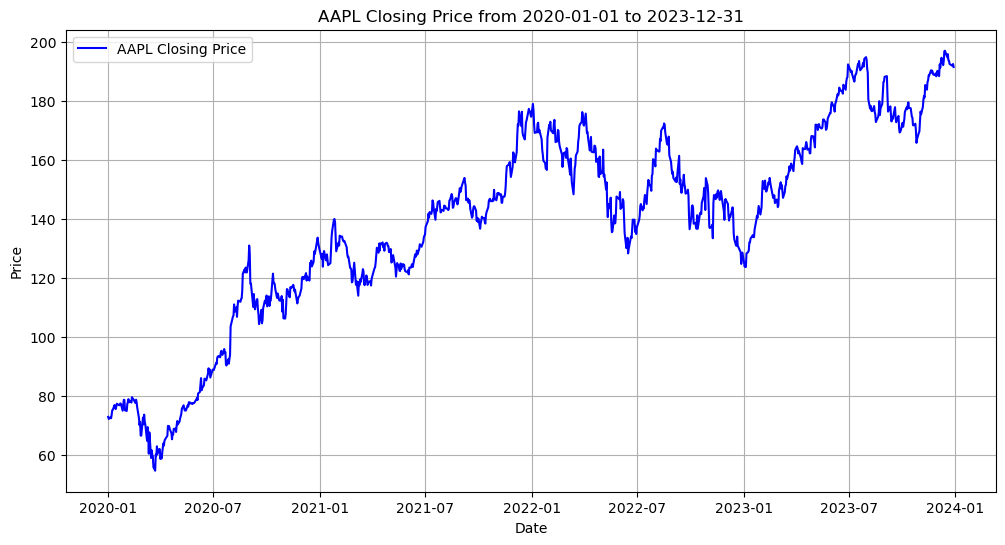

Data saved to AAPL_data.csv
Best Overall Hyperparameters:
{'long_window': 30, 'short_window': 15, 'stop_loss_pct': 0.02, 'volatility_window': 10}
Sharpe Ratio: 1.49
Total PnL: $751154.17


In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol and time period
ticker_symbol = 'AAPL'  # Example: Apple Inc.
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetch historical data using yfinance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print("Downloaded Data:")
print(stock_data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue')
plt.title(f'{ticker_symbol} Closing Price from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Save the data to a CSV file for further analysis (optional)
csv_filename = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_filename)
print(f"Data saved to {csv_filename}")

# Include 'Date' column in the new DataFrame
new_df = pd.DataFrame({
    'Date': stock_data.index,
    'Open': stock_data['Open'].values.ravel(),
    'High': stock_data['High'].values.ravel(),
    'Low': stock_data['Low'].values.ravel(),
    'Close': stock_data['Close'].values.ravel(),
    'Volume': stock_data['Volume'].values.ravel()
})


new_df['Close']

stock_data = new_df

# Calculate daily returns
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()
initial_capital = 100000  # Initial investment capital in USD


import pandas as pd
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define hyperparameter grid
param_grid = {
    'short_window': [5, 10, 15],
    'long_window': [30, 50, 70],
    'stop_loss_pct': [0.02, 0.05, 0.1],
    'volatility_window': [10, 20, 30]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Set rolling window parameters
rolling_window_size = 252  # 1 year of trading days
step_size = 21  # Monthly step size

# Store results
results = []

# Perform rolling window backtesting
for start_idx in range(0, len(stock_data) - rolling_window_size, step_size):
    # Define training and testing period
    train_data = stock_data.iloc[start_idx:start_idx + rolling_window_size].copy()
    test_data = stock_data.iloc[start_idx + rolling_window_size:start_idx + rolling_window_size + step_size].copy()

    # Evaluate each hyperparameter combination on the training data
    for params in grid:
        # Extract hyperparameters
        short_window = params['short_window']
        long_window = params['long_window']
        stop_loss_pct = params['stop_loss_pct']
        volatility_window = params['volatility_window']

        # Apply strategy on training data
        train_data['Short_MA'] = train_data['Close'].rolling(window=short_window).mean()
        train_data['Long_MA'] = train_data['Close'].rolling(window=long_window).mean()
        train_data['Signal'] = 0
        train_data.loc[train_data['Short_MA'] > train_data['Long_MA'], 'Signal'] = 1
        train_data.loc[train_data['Short_MA'] <= train_data['Long_MA'], 'Signal'] = -1
        train_data['Volatility'] = train_data['Daily_Returns'].rolling(window=volatility_window).std()
        train_data['Normalized_Returns'] = train_data['Daily_Returns'] / train_data['Volatility']
        train_data['Position_Size'] = train_data['Signal'] * train_data['Normalized_Returns']

        # Perform backtest
        capital = initial_capital
        positions = []
        pnl = []
        for i in range(1, len(train_data)):
            if train_data['Signal'].iloc[i] == 1:
                entry_price = train_data['Close'].iloc[i]
                position_size = train_data['Position_Size'].iloc[i] * capital
                quantity = position_size / entry_price
                positions.append({'entry_price': entry_price, 'quantity': quantity})
            elif train_data['Signal'].iloc[i] == -1 and len(positions) > 0:
                for position in positions:
                    exit_price = train_data['Close'].iloc[i]
                    profit = (exit_price - position['entry_price']) * position['quantity']
                    pnl.append(profit)
                    capital += profit
                positions = []

        # Calculate metrics on training data
        total_pnl = float(sum(pnl))
        sharpe_ratio = np.mean(train_data['Daily_Returns'].dropna()) / np.std(train_data['Daily_Returns'].dropna()) * np.sqrt(252)

        # Store the best parameters from training
        results.append({
            'params': params,
            'Total PnL': total_pnl,
            'Sharpe Ratio': sharpe_ratio
        })

    # Apply the best hyperparameters to test data
    best_params = max(results, key=lambda x: x['Total PnL'])['params']

    test_data['Short_MA'] = test_data['Close'].rolling(window=best_params['short_window']).mean()
    test_data['Long_MA'] = test_data['Close'].rolling(window=best_params['long_window']).mean()
    test_data['Signal'] = 0
    test_data.loc[test_data['Short_MA'] > test_data['Long_MA'], 'Signal'] = 1
    test_data.loc[test_data['Short_MA'] <= test_data['Long_MA'], 'Signal'] = -1
    test_data['Volatility'] = test_data['Daily_Returns'].rolling(window=best_params['volatility_window']).std()
    test_data['Normalized_Returns'] = test_data['Daily_Returns'] / test_data['Volatility']
    test_data['Position_Size'] = test_data['Signal'] * test_data['Normalized_Returns']

    # Perform backtest on test data (similar logic as above)

# After completing all rolling windows, analyze the aggregated results
best_overall_result = max(results, key=lambda x: x['Total PnL'])

# Print final results
print("Best Overall Hyperparameters:")
print(best_overall_result['params'])
print(f"Sharpe Ratio: {best_overall_result['Sharpe Ratio']:.2f}")
print(f"Total PnL: ${best_overall_result['Total PnL']:.2f}")